In [26]:
import numpy as np
from scipy.stats import multivariate_normal


In [27]:

class EMGMM:
    def __init__(self, n_components, n_features, low_value=-2.0, high_value=2.0, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.n_features = n_features
        self.max_iter = max_iter
        self.tol = tol

        # Initialize parameters
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = np.random.uniform(low=low_value, high=high_value, size=(self.n_components, n_features))
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])


    def fit(self, X):
        log_likelihood_old = 0

        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self._e_step(X)
            
            # M-step
            self._m_step(X, responsibilities)

            # Compute log-likelihood
            log_likelihood = self._log_likelihood(X)
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood
            print(f"Iteration {iteration + 1}, Log-likelihood: {-log_likelihood}")
    
    def _e_step(self, X):
        weighted_pdfs = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            weighted_pdfs[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        responsibilities = weighted_pdfs / weighted_pdfs.sum(axis=1, keepdims=True)
        return responsibilities

    def _m_step(self, X, responsibilities):
        N_k = responsibilities.sum(axis=0)
        self.weights = N_k / X.shape[0]
        self.means = (responsibilities.T @ X) / N_k[:, None]
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k][:, None] * diff).T @ diff / N_k[k]

    def _log_likelihood(self, X):
        log_likelihood = 0
        for k in range(self.n_components):
            log_likelihood += self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        return np.sum(np.log(log_likelihood))
    
    def predict(self, X):
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)


In [28]:
# # Generate synthetic data
# np.random.seed(42)
# mean1 = [2, 2]
# cov1 = [[0.5, 0.0], [0.0, 0.5]]
# mean2 = [-2, -2]
# cov2 = [[1, 0.0], [0.0, 1]]

# data1 = np.random.multivariate_normal(mean1, cov1, 150)
# data2 = np.random.multivariate_normal(mean2, cov2, 150)
# X = np.vstack((data1, data2))

# # Apply EM algorithm
# em_gmm = EMGMM(n_components=2)
# em_gmm.fit(X)
# predictions = em_gmm.predict(X)

# # Display results
# print("Means:")
# print(em_gmm.means)
# print("Covariances:")
# print(em_gmm.covariances)
# print("Cluster Assignments:")
# print(predictions)


Iteration 1, Log-likelihood: 1176.4390038946508
Iteration 2, Log-likelihood: 1173.1705500368957
Iteration 3, Log-likelihood: 1170.5663996332953
Iteration 4, Log-likelihood: 1168.7693733081042
Iteration 5, Log-likelihood: 1167.7062099049447
Iteration 6, Log-likelihood: 1167.1219126806905
Iteration 7, Log-likelihood: 1166.7706016837592
Iteration 8, Log-likelihood: 1166.4981582394976
Iteration 9, Log-likelihood: 1166.2236061301983
Iteration 10, Log-likelihood: 1165.8971275370109
Iteration 11, Log-likelihood: 1165.468745767212
Iteration 12, Log-likelihood: 1164.8620955073472
Iteration 13, Log-likelihood: 1163.9333499962556
Iteration 14, Log-likelihood: 1162.373183819952
Iteration 15, Log-likelihood: 1159.4231156261671
Iteration 16, Log-likelihood: 1152.9426776888204
Iteration 17, Log-likelihood: 1136.2838254563999
Iteration 18, Log-likelihood: 1093.5001864673982
Iteration 19, Log-likelihood: 1039.4390533759258
Iteration 20, Log-likelihood: 1012.0895863208755
Iteration 21, Log-likelihood: 9

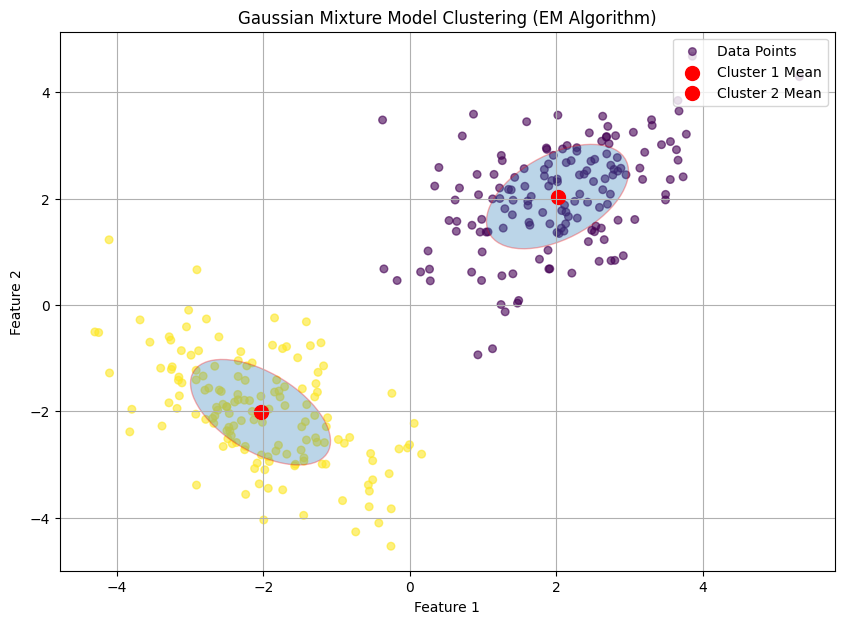

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_results(X, predictions, means, covariances):
    plt.figure(figsize=(10, 7))
    
    # Scatter plot of data points with cluster assignments
    plt.scatter(X[:, 0], X[:, 1], c=predictions, cmap='viridis', s=30, alpha=0.6, label="Data Points")
    
    # Plot Gaussian ellipses
    for i in range(len(means)):
        plot_gaussian_ellipse(means[i], covariances[i], edgecolor='red')
        plt.scatter(means[i][0], means[i][1], c='red', s=100, label=f"Cluster {i+1} Mean")
    
    plt.title("Gaussian Mixture Model Clustering (EM Algorithm)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

def plot_gaussian_ellipse(mean, covariance, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    eigvals, eigvecs = np.linalg.eigh(covariance)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals)
    ellipse = Ellipse(mean, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)
    ellipse.set_alpha(0.3)

# Generate synthetic data
np.random.seed(42)

mean1 = [2, 2]
cov1 = [[1, 0.5], [0.5, 1]]
mean2 = [-2, -2]
cov2 = [[1, -0.5], [-0.5, 1]]

data1 = np.random.multivariate_normal(mean1, cov1, 150)
data2 = np.random.multivariate_normal(mean2, cov2, 150)
X = np.vstack((data1, data2))
X = X[np.random.permutation(len(X))]


# Apply EM algorithm
em_gmm = EMGMM(n_components=2, n_features=len(mean1), max_iter=100)
em_gmm.fit(X)
predictions = em_gmm.predict(X)

# Visualize results
plot_results(X, predictions, em_gmm.means, em_gmm.covariances)
